In [169]:
%load_ext autoreload
%autoreload 2

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("../../azimuth.env")

# Add PATH_ROOT to Python path
import sys
sys.path.append(os.getenv("PATH_ROOT"))

print(f'PATH_ROOT: {os.getenv("PATH_ROOT")}')
# Set the style for publication-quality plots
plt.style.use('seaborn-v0_8-paper')  # Clean, professional style
plt.rcParams.update({
    'font.family': 'serif',  # Use serif fonts
    'font.serif': ['Arial'],  # Use Times New Roman
    'font.size': 10,         # Readable font size
    'axes.linewidth': 1.0,   # Thicker axes lines
    'axes.labelsize': 10,    # Size for axis labels
    'xtick.labelsize': 10,    # Size for x-tick labels
    'ytick.labelsize': 10,    # Size for y-tick labels
})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PATH_ROOT: /Users/thinhhoang/Documents/alpha-azimuth/


In [170]:
# Testing Thomas-Jensen Transit Process

import MARTINI.airspace.randomize_airspace as randomize_airspace
import MARTINI.arrivals.thomas as thomas
import MARTINI.airspace.geo as geo
import MARTINI.airspace.intersect as intersect
import numpy as np

# Generate a polygon
polygon, area = randomize_airspace.generate_unit_polygon(5, 500, seed=69420)

np.random.seed(69420)

entry_points, exit_points, velocity_vectors, parent_indices = thomas.generate_problem_thomas_jensen(polygon, lambda_parent=8e-3, mu=2, sigma=12,
                                                                                                    min_dist_to_vertex=42, min_transit_length=96,
                                                                                                    random_state=69420)
print(f'There are {len(entry_points)} entries generated')
print(f'There are {len(exit_points)} exits generated')
print(f'There are {len(velocity_vectors)} velocity vectors generated')


There are 36 entries generated
There are 36 exits generated
There are 36 velocity vectors generated


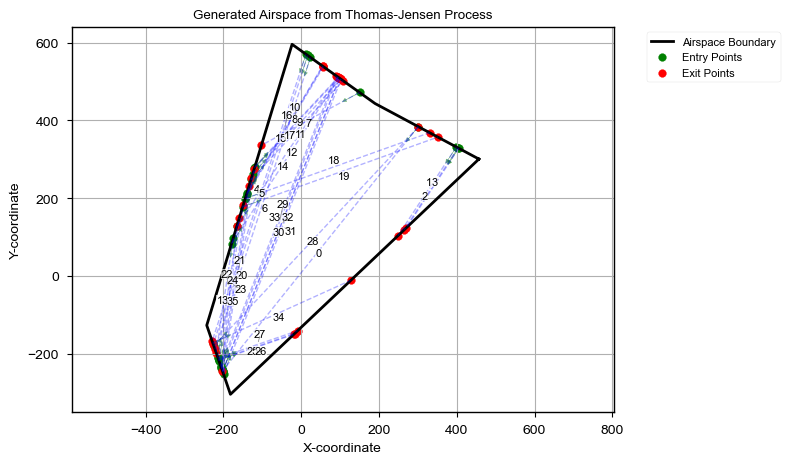

In [171]:
thomas.visualize_airspace(polygon, entry_points, exit_points, velocity_vectors)

In [172]:
trajectories = [[x, y] for x, y in zip(entry_points, exit_points)]
trajectories = np.array(trajectories)

print(f'There are {len(trajectories)} trajectories generated')

There are 36 trajectories generated


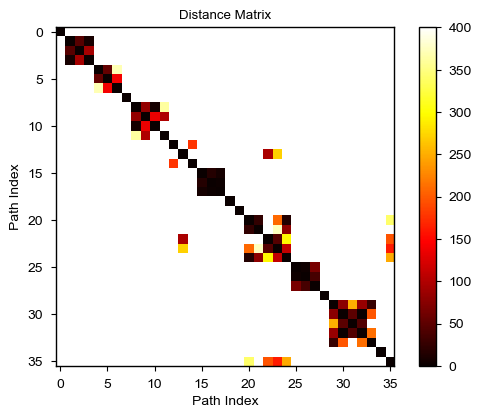

In [173]:
from matplotlib import pyplot as plt
import numpy as np
# Compute the distance matrix
from ALPHA.dirichlet.trajclus_features import compute_distance_matrix
from ALPHA.dirichlet.hdbs import perform_clustering
from ALPHA.dirichlet.trajclus_features import compute_segment_features_auto

distance_matrix = compute_distance_matrix(trajectories,
                                          allow_cutoff=True, max_distance=400,
                                          max_dt=0.3)
# Visualize the distance matrix
plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Distance Matrix')
plt.xlabel('Path Index')
plt.ylabel('Path Index')
plt.show()



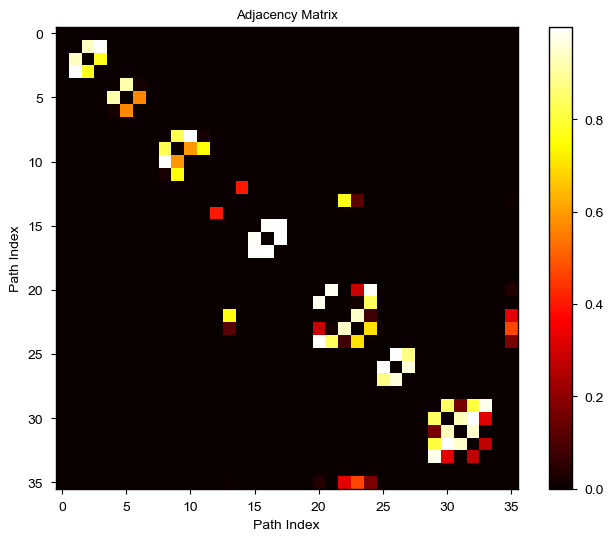

In [174]:
# Replace inf values in distance matrix with zeros in similarity calculation
similarity_matrix = np.copy(distance_matrix)
similarity_matrix[np.isinf(similarity_matrix)] = 0


# Convert distance matrix to similarity matrix using Gaussian kernel
sigma = np.mean(similarity_matrix[similarity_matrix > 0])  # Can be tuned based on your needs
# Only apply exponential transformation to non-zero values
nonzero_mask = similarity_matrix != 0
similarity_matrix[nonzero_mask] = np.exp(-similarity_matrix[nonzero_mask]**2 / (2 * sigma**2))
adjacency_matrix = similarity_matrix

# Visualize the adjacency matrix
plt.figure(figsize=(8, 6))
plt.imshow(adjacency_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Adjacency Matrix')
plt.xlabel('Path Index')
plt.ylabel('Path Index')
plt.show()

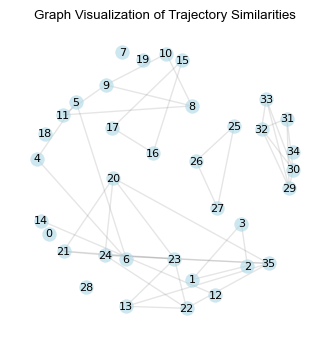

In [178]:
import networkx as nx

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adjacency_matrix)

# Set up the plot
plt.figure(figsize=(4, 4))

# Calculate node positions using a spring layout
# You can experiment with different layout algorithms like spring_layout, kamada_kawai_layout, circular_layout
pos = nx.spring_layout(G, k=1, iterations=50)

# Draw the network
# Nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                      node_size=100, alpha=0.6)

# Edges - only draw edges with weight above a threshold to reduce clutter
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
threshold = 0  # You can adjust this threshold
edges = [(u, v) for (u, v) in G.edges() if G[u][v]['weight'] > threshold]
nx.draw_networkx_edges(G, pos, edgelist=edges, 
                      alpha=0.2, edge_color='gray')

# Add labels
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title('Graph Visualization of Trajectory Similarities')
plt.axis('off')
plt.show()

In [176]:
from ALPHA.dirichlet.leiden import leiden_community_detection
communities, quality = leiden_community_detection(adjacency_matrix,
                                                  resolution=0.1,
                                                  n_iterations=50)
    
print(f"Found {len(np.unique(communities))} communities")
print(f"Partition quality: {quality}")

for i in range(len(np.unique(communities))):
    print(f"Community {i}: {np.sum(np.array(communities) == i)} trajectories")


Found 14 communities
Partition quality: 104.6973261424349
Community 0: 7 trajectories
Community 1: 5 trajectories
Community 2: 4 trajectories
Community 3: 3 trajectories
Community 4: 3 trajectories
Community 5: 3 trajectories
Community 6: 3 trajectories
Community 7: 2 trajectories
Community 8: 1 trajectories
Community 9: 1 trajectories
Community 10: 1 trajectories
Community 11: 1 trajectories
Community 12: 1 trajectories
Community 13: 1 trajectories


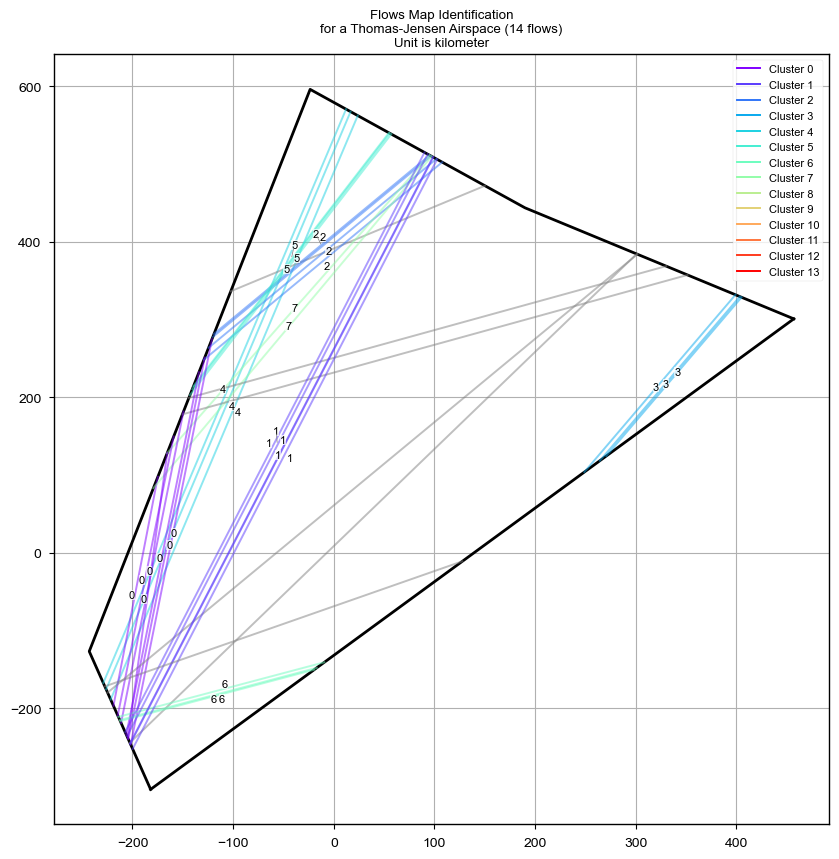

In [177]:
# Plot the airspace boundary
plt.figure(figsize=(10, 10))
plt.plot(polygon[:, 0], polygon[:, 1], 'k-', linewidth=2, label='Airspace Boundary')
plt.plot([polygon[-1, 0], polygon[0, 0]], [polygon[-1, 1], polygon[0, 1]], 'k-', linewidth=2)

# Plot the clusters
unique_labels = np.unique(communities)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# Create a legend handle list and color mapping
legend_elements = []
color_dict = {}  # Create a mapping of label to color

for idx, (label, color) in enumerate(zip(unique_labels, colors)):
    if label == -1:
        color_dict[label] = 'gray'
        legend_elements.append(plt.Line2D([0], [0], color='gray', label='Noise'))
    else:
        color_dict[label] = color
        legend_elements.append(plt.Line2D([0], [0], color=color, label=f'Cluster {label}'))
        
# Plot trajectories
for i in range(trajectories.shape[0]):
    # Check if this trajectory's community has only one member
    if np.sum(np.array(communities) == communities[i]) == 1:
        color = 'gray'  # Use grey for single-member communities
    else:
        color = color_dict[communities[i]]
    plt.plot(trajectories[i, :, 0], trajectories[i, :, 1], c=color, alpha=0.5)

# Add trajectory labels with overlap handling
texts = []
for i in range(trajectories.shape[0]):
    # Get midpoint of trajectory for initial text position
    mid_x = np.mean(trajectories[i, :, 0])
    mid_y = np.mean(trajectories[i, :, 1])
    
    # Add text with white background for better visibility
    text = plt.text(mid_x, mid_y, str(communities[i]) if np.sum(np.array(communities) == communities[i]) > 1 else '',
                   fontsize=8,
                   bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0),
                   horizontalalignment='center',
                   verticalalignment='center')
    texts.append(text)

# Try to prevent text overlap using adjustText if available
try:
    from adjustText import adjust_text
    adjust_text(texts,
               arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
               expand_points=(1.5, 1.5))
except ImportError:
    print('adjustText not available, keeping simple text labels')
    pass

plt.title(f'Flows Map Identification\nfor a Thomas-Jensen Airspace ({len(unique_labels)} flows)\nUnit is kilometer')
plt.legend(handles=legend_elements)
plt.grid(True)
plt.show()
